# Ptychography Tutorial 01

This is the first tutorial notebook in the iterative ptychography series.  
In this tutorial notebook we will cover:
- Quick introduction to iterative ptychography
- Single-slice reconstruction of simulated data

### Downloads
This tutorial uses the following datasets:
- [ptycho_ducky_simulation_01.h5](https://drive.google.com/file/d/1VtYVHWiuI8AT0yucaylIcQQJ_px79ash/view?usp=drive_link)
- [ptycho_ducky_vacuum-probe_01.h5](https://drive.google.com/file/d/1CeVGVvMf2QeJK1ADQ9MBK308NhvoVaVn/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2024 May 6

## Introduction

Iterative ptychography is a phase retrieval method which attempts to reconstruct the scattering potential of an electron-transparent sample as well as the incoming probe illumination using a set of converged probe diffraction intensities, i.e. a 4D-STEM experiment.

Iterative ptychography is a model-based iterative reconstruction method, and thus relies on setting up an accurate forward model. Thankfully, we know how to simulate 4D-STEM experiments quite well (see e.g. the [abTEM](https://abtem.readthedocs.io/en/latest/intro.html) and [Prismatic](https://prism-em.com/) software), and thus it's reasonable to expect we might be able to invert them! 

Depending on the type of assumptions we make for the scattering physics, we are able to reconstruct increasingly complex samples and phenomena using appropriate forward and adjoint models. Below is an incomplete table summarizing these phenomena and the relevant py4DSTEM classes:

| **Applicability/Physical Phenomenon**  | **Conventional Name/Reference**                                                                                | **py4DSTEM class**      |
|----------------------------------------|----------------------------------------------------------------------------------------------------------------|-------------------------|
| Thin or weakly-scattering objects      | [Single-slice ptychography](https://www.sciencedirect.com/science/article/pii/S0304399109001284)               | SingleslicePtychography |
| 'Thick' or multiply-scattering objects | [Multi-slice ptychography](https://www.science.org/doi/10.1126/science.abg2533)                                | MultislicePtychography  |
| Partial probe coherence                | [Mixed-state ptychography](https://www.nature.com/articles/nature11806)                                        | MixedstatePtychography  |
| Tilt-series of 'thick' objects         | [Joint ptychographic tomography](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.054062) | PtychographicTomography |
| Incoherent (e.g. thermal) scattering   | Open question in the field!                                                                                    | N/A                     |

## Single-slice Ptychography

The simplest forward model is single-slice ptychography, which uses a multiplicative assumption to model the exit-wave wavefunction as a function of probe position $\boldsymbol{R}_j$:

$$
\begin{align}
    \psi_j(\boldsymbol{r}) &= \mathcal{P}(r) \times \mathcal{O}(\boldsymbol{r}-\boldsymbol{R}_j) \\
    I_j(\boldsymbol{k}) &= \left|\mathcal{F}\left[\psi_j\right] \right|^2,
\end{align}
$$

where $\mathcal{P}(\boldsymbol{r})$ is the incoming probe-illumination, $\mathcal{O}(\boldsymbol{r}-\boldsymbol{R}_j)$ is the complex-valued scattering object we wish to reconstruct, $\mathcal{F}$ is the Fourier transform operator, and $I_j(\boldsymbol{k})$ are the far-field diffraction intensities predicted by the model.


In iterative ptychography we start with an initial guess for the illuminating probe (e.g. a perferct Airy probe) and the scattering potential (usually empty), and iteratively update the scattering potential and the illuminating probe to match measured diffraction intensities. Let's try this!

### Measured Diffraction Intensities

First, we load the simulated data;

In [1]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

0.14.18


In [8]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI',
    destination = '/Users/wendy/github_python/py4DSTEM_tutorials/data',
    filename = 'ptycho_ducky_simulation_03.h5',
    overwrite=True
)

# Get the probe
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM',
    destination = '/Users/wendy/github_python/py4DSTEM_tutorials/data',
    filename = 'ptycho_ducky_vacuum-probe_03.h5',
    overwrite=True
)

Downloading...
From (original): https://drive.google.com/uc?id=1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI
From (redirected): https://drive.google.com/uc?id=1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI&confirm=t&uuid=bf033114-fc4a-4ecc-a231-28aa3caa062d
To: /Users/wendy/github_python/py4DSTEM_tutorials/data/ptycho_ducky_simulation_03.h5
100%|██████████| 538M/538M [00:06<00:00, 81.2MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM
To: /Users/wendy/github_python/py4DSTEM_tutorials/data/ptycho_ducky_vacuum-probe_03.h5
100%|██████████| 336k/336k [00:00<00:00, 11.3MB/s]


In [11]:
file_path = '/Users/wendy/github_python/py4DSTEM_tutorials/data/'
file_data = file_path + 'ptycho_ducky_simulation_03.h5'

dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (41, 41, 200, 200) called 'datacube',
          with dimensions:

              Rx = [0.0,4.0,8.0,...] A
              Ry = [0.0,4.0,8.0,...] A
              Qx = [0.0,0.025,0.05,...] A^-1
              Qy = [0.0,0.025,0.05,...] A^-1
)

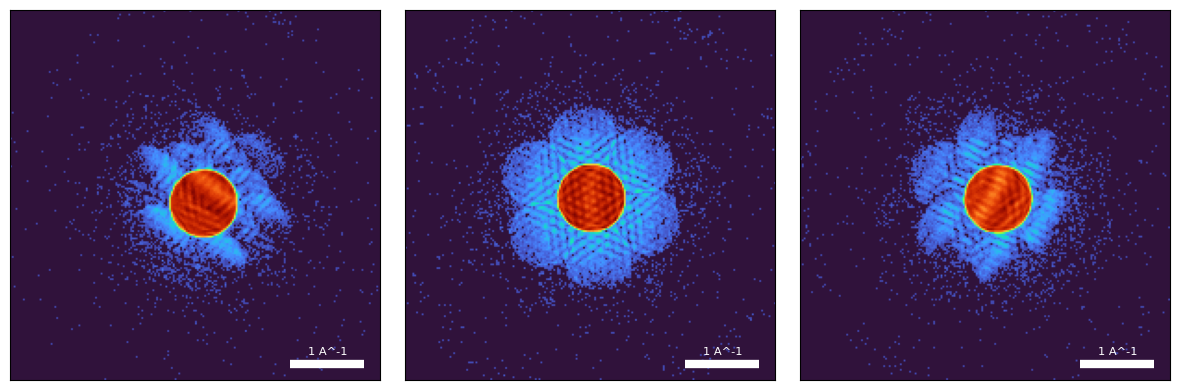

In [12]:
py4DSTEM.show(
    [
        dataset[11,24],
        dataset[18,24],
        dataset[11,12],
    ],
    cmap='turbo',
    vmax=1,
    power=0.333,
    axsize=(4,4),
    scalebar=True,
    ticks=False,
    pixelsize=dataset.calibration.get_Q_pixel_size(),
    pixelunits=dataset.calibration.get_Q_pixel_units(),
)

Plotting a few of the diffraction patterns, we see that:
- Most of the scattering is contained inside the bright-field disk
- We collect diffraction intensities to large scattering angles (this enables super-resolution)
- The diffracted disks overlap (enabling unambiguous "phasing" of the scattering potential)
- There are imprints of the scattering potential inside the bright and scattered disks (this so-called "shadowgram" is due to the large defocus)

In addition to our simulation over the sample potential, we also simulate the diffraction pattern over vacuum at the same camera-length and detector resolution.  
This "vacuum probe measurement" (which can be downloaded [here](https://drive.google.com/file/d/1xJgQoxhWMBbtknwRfqB_BkULvgiJe-c1/view?usp=share_link)), is very important, as we will see in the regularizations tutorial.

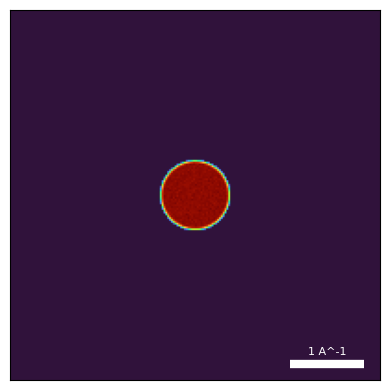

In [13]:
file_probe = file_path + 'ptycho_ducky_vacuum-probe_03.h5'
probe = py4DSTEM.read(file_probe)

py4DSTEM.show(
    probe.data,
    cmap='turbo',
    vmax=1,
    power=0.333,
    figsize=(4,4),
    ticks=False,
    scalebar=True,
    pixelsize=dataset.calibration.get_Q_pixel_size(),
    pixelunits=dataset.calibration.get_Q_pixel_units(),
)

### Pre-processing

Before we can reconstruct our dataset, we need to perform some pre-processing steps:
- Estimate the relationship between the real-space and reciprocal-space coordinate systems
- Correct for any residual descan errors, and properly center the diffraction intensities
- Initialize the illuminate probe and probe positions inside the object field of view

These can all be performed using the `preprocess` method common to all `*Ptychography` classes.

__Note:__ all the `phase_contrast` class methods implement "chaining":
- That is, they return `self` so you can call them as follows: `ptycho = *Ptychography().preprocess().reconstruct().visualize()`
- It might look funny at first, but we think you'll grow to like this pattern!

In [17]:
py4DSTEM.process.phase.SingleslicePtychography(energy = 80e3)

SingleslicePtychography( A Node called 'ptychographic_reconstruction', containing the following top-level objects in its tree:

)

Best fit rotation = -15 degrees.
Normalizing amplitudes: 100%|██████████| 1681/1681 [00:03<00:00, 446.39probe position/s]


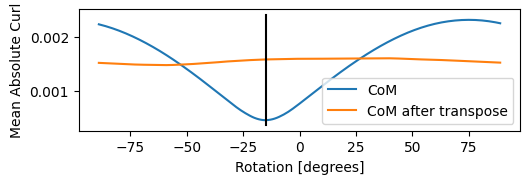

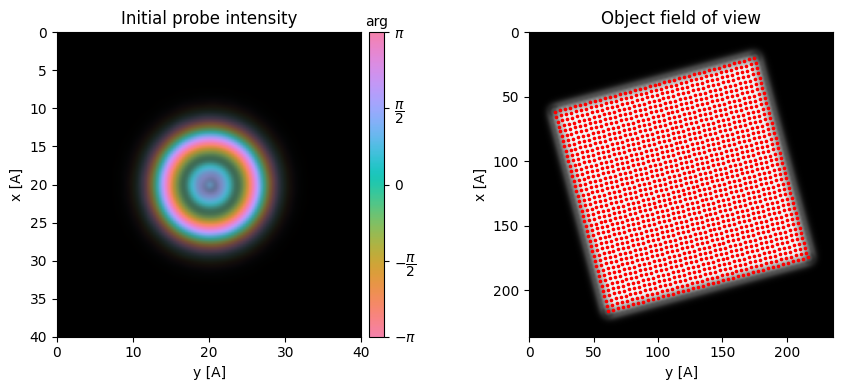

In [18]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset, #py4DSTEM DataCube
    energy=80e3, # energy in eV
    defocus=500, # defocus guess in A
    vacuum_probe_intensity=probe.data, # vacuum probe measurement array
    device='cpu',#'gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False, # omit one of the intermediate DPC plots 
)

Let's break down what the code above did:
- The first step is to calibrate the reciprocal coordinate system to our real-space scan coordinate system
  - These two coordinate systems need not be aligned, and in-fact vary microscope by microscope due to the physical placement of the detector, the helical path electrons take along the optic axis, etc.
  - If you have calibrated this before, you can force the value in degrees using the `force_com_rotation` flag in `preprocess`. 
  - If not, the code will attempt to solve for this relative rotation value by minimizing the curl (or optionally maximing the divergence) of the CoM gradient
    - Note this procedure has a 180 degree ambiguity!

In [19]:
print(f"Estimated rotation: {np.rad2deg(ptycho._rotation_best_rad)} degrees.")

Estimated rotation: -15.0 degrees.


- The next step is to align the measured diffraction patterns to the probe aperture:
  - To do this, we first correct for any residual descan errors
  - And then shift the diffraction pattern _amplitudes_ to the origin (note internally we define this origin as the top-left corner of the array)

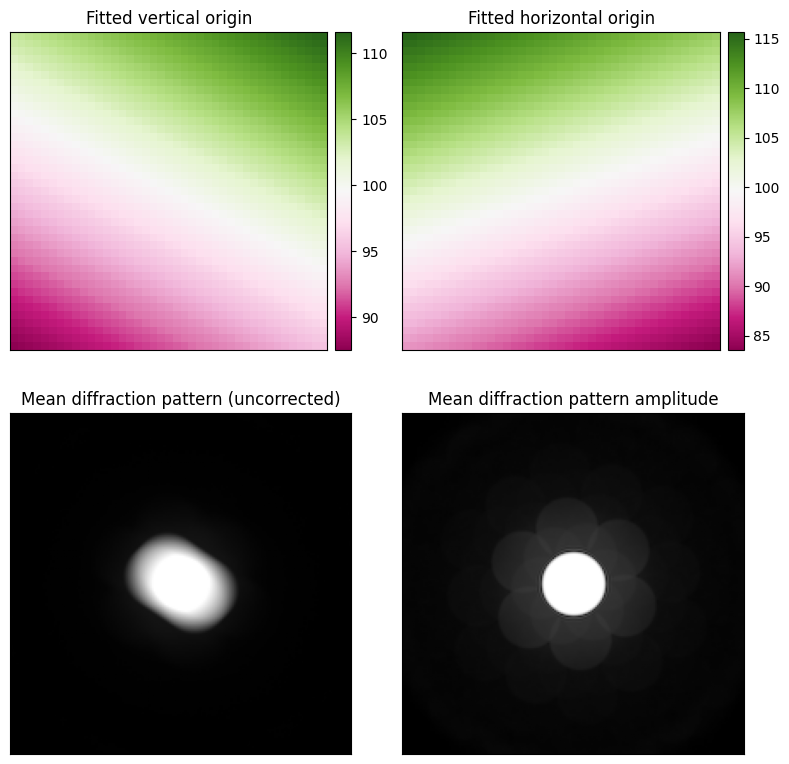

In [20]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

arrs = (ptycho._com_fitted_x,ptycho._com_fitted_y)
titles = ["Fitted vertical origin", "Fitted horizontal origin"]

for arr, ax, title in zip(arrs, axs.flat, titles):
    py4DSTEM.show(
        arr,
        cmap='PiYG',
        figax=(fig,ax),
        ticks=False,
        title=title,
        show_cbar=True,
        vmin=0,vmax=1,
    )


py4DSTEM.show(
    dataset.data.mean((0,1)), # fft-shifted to center for visualization
    power=0.5,
    ticks=False,
    title="Mean diffraction pattern (uncorrected)",
    figax=(fig,axs[1,0]),
)

py4DSTEM.show(
    np.fft.fftshift(ptycho._amplitudes.mean(0)), # fft-shifted to center for visualization
    power=0.5,
    ticks=False,
    title="Mean diffraction pattern amplitude",
    figax=(fig,axs[1,1]),
)

fig.tight_layout()

- Now that we have the coordinate systems aligned, we want to initialize our probe and position it on the object fov. This requires two things:
  - A guess for the probe aperture
    - We can either use a "perfect" circular aperture with soft edges by specifying the `semiangle_cutoff` in mrad
      - Often, microscopes have severe aperture artifacts and/or ellipticity and this is a bad guess
    - **Alternatively, we suggest you always collect a vacuum probe measurement with the same camera-length and defocus before/after your experiment.**
      - See additional tutorials on the importance of doing this
  - A guess for the probe aberrations (notably defocus)
    - Here, we know the simulated defocus exactly
    - See additional tutorials on how to estimate this using i) the parallax reconstruction, ii) Bayesian Optimization

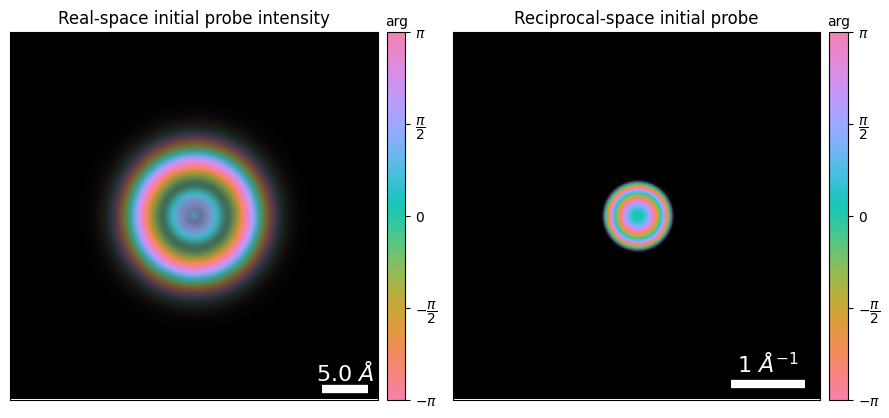

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4.5))

ptycho.show_probe(
    figax=(fig,ax1),
    power=2,
    title="Real-space initial probe intensity",
)
ptycho.show_fourier_probe(
    figax=(fig,ax2),
    title="Reciprocal-space initial probe",
)

fig.tight_layout()

#### Pixel-sizes, fields-of-view, and array sizes

__Note:__ The probe is defined in a `region_of_interest_shape` array which is often smaller than the object field-of-view. This allows for computational efficiency, but can lead to artifacts if this "cropping box" is too small.

More generally, the reconstruction pixel-size and field-of-view is directly specified by the dataset calibrations:
- The reconstruction pixel-size (`ptycho.sampling`) is given by the inverse of twice the maximum scattering angle $\Delta x = k_{\mathrm{max}}^{-1}/2=\left(\Delta k \times N\right)^{-1}$
- The probe field-of-view is then given by multiplying this pixel-size by the probe `region_of_interest_shape`

In [22]:
print(f"Pixel-size, Δx:{np.array(ptycho.sampling)} A")
print(f"Probe region_of_interest_shape:{ptycho._region_of_interest_shape} pixels")
print(f"Probe region_of_interest FOV:{np.array(ptycho.sampling)*ptycho._region_of_interest_shape} A")
print(f"Reconstructed object FOV:{np.array(ptycho.sampling)*ptycho._object_shape} A")

Pixel-size, Δx:[0.2 0.2] A
Probe region_of_interest_shape:[200 200] pixels
Probe region_of_interest FOV:[40. 40.] A
Reconstructed object FOV:[236. 236.] A


See tutorial on choosing experimental parameters for more information.

### Reconstruction

We are now ready to reconstruct our scattering potential! The `reconstruct()` function -- common to all the `phase_contrast` classes -- takes _a lot_ of optional flags.  
These mostly related to object and probe regularizations and we will investigate them as we go along the tutorial series.  
For now, we simply specify the number of iterations and how many probe positions to use at every update step (`max_batch_size`).

In [14]:
ptycho = ptycho.reconstruct(
    reset=True , # restart reconstruction
    seed_random=0, # for reproducibility
    num_iter = 64, # number of iterations to run
    max_batch_size=512, # how many probe positions to update at once
).visualize(
)

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step_size: 0.5, in batches of max 512 measurements.
Reconstructing object and probe:   6%|▋         | 4/64 [00:37<09:22,  9.38s/ iter]

The reconstruction is pretty good, revealing our "atomically-resolved" ducky!  
However, if you look carefully it has various artifacts:  
- The reconstructed probe is rather noisy
- The reconstructed object exhibits "gridding"

Both of these are related to a known pathology in ptychography associated with periodic artifacts of a raster-scan. See tutorial on common artifacts for more information.

For now, let's investigate some common visualization functions:
- First, we can plot the reconstructed real and reciprocal probes using `show_probe()` and `show_fourier_probe()` respectively:

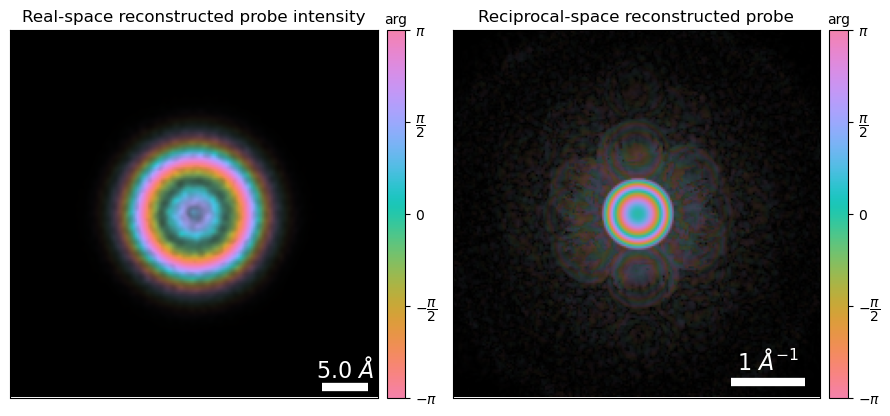

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4.5))

ptycho.show_probe(
    figax=(fig,ax1),
    power=2,
    title="Real-space reconstructed probe intensity",
)
ptycho.show_fourier_probe(
    figax=(fig,ax2),
    title="Reciprocal-space reconstructed probe",
    power=0.25
)

fig.tight_layout()

Notice how the reconstructed reciprocal-space probe has significant intensity outside the aperture, which suspiciously resembles "diffracted disks". This is called "probe-object mixing" and is a consequence of the entire field of view being crystalline, suggesting that the algorithm can match the measured data by dumping the mean diffraction pattern into the probe update. 

See tutorial on object and probe constraints on more information for how to constrain this.

- Secondly, we can investigate the reconstructed object and its Fourier transform by the `object_cropped` property and the `show_object_fft()` function:

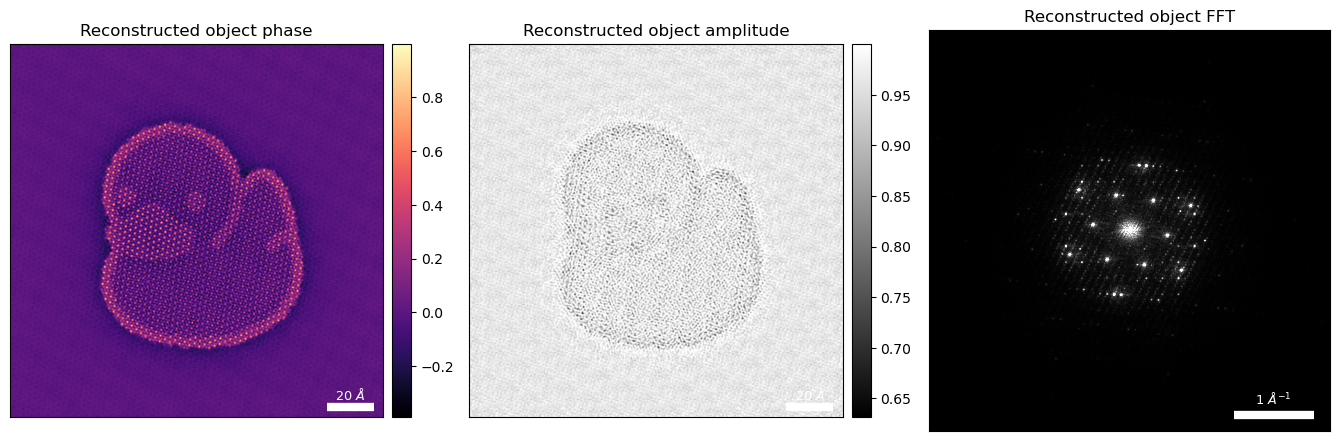

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13.5,4.5))

kwargs = {"vmin":0,"vmax":1,"ticks":False,"scalebar":True,"pixelsize":ptycho.sampling[0],"pixelunits":r"$\AA$"}

py4DSTEM.show(
    np.angle(ptycho.object_cropped),
    figax=(fig,ax1),
    title="Reconstructed object phase",
    show_cbar=True,
    cmap='magma',
    **kwargs
)

py4DSTEM.show(
    np.abs(ptycho.object_cropped),
    figax=(fig,ax2),
    title="Reconstructed object amplitude",
    show_cbar=True,
    **kwargs
)

ptycho.show_object_fft(
    figax=(fig,ax3),
    title="Reconstructed object FFT",
    cmap="grey",
)

fig.tight_layout()

Notice that:
- The raster-scan pathology "gridding" is quite evident in the reconstructed object FFT
- We have significant amplitude variations in our reconstruction
  - This is an additional indication of model mismatch, since we expect our thin atomic model for ducky to be a fairly weak-phase object
  - __Note:__ some amplitude loss _can_ be physical, e.g. due to scattered electrons to angles larger than our collection angle

In [17]:
amp = np.abs(ptycho.object_cropped)
print(f"Reconstructed amplitude, (min,max):{(amp.min(),amp.max())}")

Reconstructed amplitude, (min,max):(0.6318792, 0.99999994)


We can enforce that our reconstructed object is a pure-phase object, by constraining the amplitude to unity, or better yet perform gradient descent on the potential object directly:
$$
\mathcal{O}(\boldsymbol{r}-\boldsymbol{R}_j) = \mathrm{exp}\left(\mathrm{i}\mathcal{V}(\boldsymbol{r}-\boldsymbol{R}_j)\right)
$$

In addition to be more computationally performant, this allows us to enforce physical-based constraints on the object (such as `object_positivity`)

Performing 64 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.5, in batches of max 512 measurements.
Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 64/64 [00:09<00:00,  6.58 iter/s]


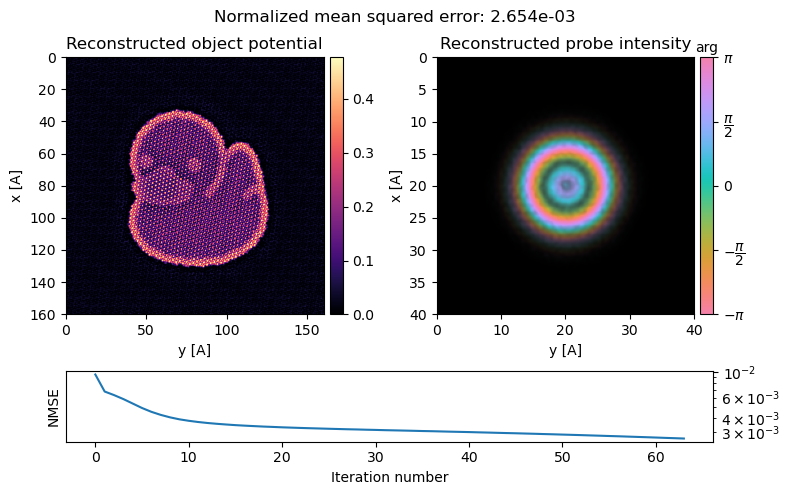

In [18]:
ptycho = ptycho.reconstruct(
    seed_random=0, 
    reset=True,
    max_batch_size=512, 
    num_iter = 64, 
    object_type="potential", # use a pure-phase potential object
    object_positivity=True, # enforce potential positivity
).visualize(
)

This looks better indeed, but still suffers from gridding. We will investigate the origins of this in the next tutorial.